# streeteasy_model: Exploratory analysis.

The purpose of this notebook is to analyze rental listings data from streeteasy as a preliminary step to develop a model-based web applicationt to assess the relative value of a rental listing.  The data were scraped from streeteasy.com from 11/02/2016 to 1/31/2017 and stored in the SQLite database, rentnyc_db.  Here, I analyze the key variables to inform feature engineering for modeling rental price.  

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

## Query the database

In [7]:
#connect to database, set up cursor, query the table
con = sqlite3.connect('../db/streeteasy_db')
c = con.cursor()
df = pd.read_sql("SELECT * FROM 'all_data'",con) #create a table named 20161005
#eliminate unnamed column
if 'Unnamed: 0' in df:
    df = df.drop('Unnamed: 0',1);
#print summary
[n,p] = df.shape
print n, "observations (listings)"
print p, "features\n"

63238 observations
74 features



# Variables

## data_id: 
A unique identifier associated with each listing.  


Ensure that all duplicates are properly removed by ensuring each data_id is unique.

In [13]:
#ensure unique listings
print "%d total observations." % (np.shape(df['data_id']))
print "%d unique observations." % (np.shape(df['data_id'].unique()))

63238 total observations.
63238 unique observations.


## Price
Price associated with each listing in US dollars per month (USD/mo).

### Missing data.

This is our target variable for prediction. No data should be missing.

In [4]:
n_missing = sum(pd.isnull(df['price']))
print "Num observations missing price: ", np.sum(n_missing)

Num observations missing price:  0


### Distribution

The distribution is positively skewed with a long tail.  The long tail is likely to inflate some of the error metrics since we have a few large values with high variability.  One approach is to simply exclude extreme values.  This will mean that our model is invalid outside of the inclusion range, but this may not be a problem if the range is adequately large for our purposes.  The second approach is to transform the target variable to eliminate the skew, which can help ensure normally-distributed residuals for statistical inference about fitted coefficients.  However, our primary goal is prediction, and it is not necessarily the case that this will yield lower overall prediction error in original units (USD/mo).   

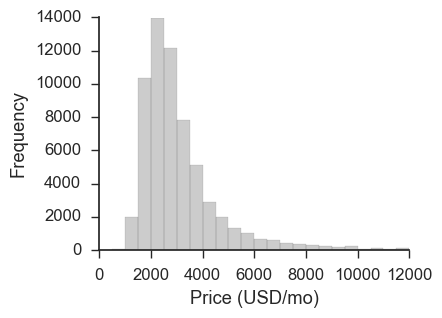

In [20]:
save_on=0
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.2)
plt.figure(figsize=(4,3))
bins_ = np.arange(1,20000,500)
ax = sns.distplot(df.price,bins=bins_,kde=False, hist_kws={"color": (0,0,0), "alpha": 0.2});
ax.set_xlim([0,12000])
ax.set_xlabel('Price (USD/mo)')
ax.set_ylabel('Frequency')
sns.set_style("ticks")
sns.despine()
if save_on:
    plt.savefig('price_hist_raw.png',dpi=600,edgecolor='k')
    plt.savefig('price_hist_raw.pdf',format='pdf')


Only 0.69% of the data fall above $20,000/mo, meaning that we could exclude these data without too much loss of generalizability.

In [21]:
#how much data falls above $20,000?
n_over_20k = df.loc[df['price'] > 20000].shape[0]
n_over_20k = float(n_over_20k)
print "total observations = ", float(n)
print "total above 20k = ", float(n_over_20k)
x =float(n_over_20k)/float(n)*100
print "Percent above 20k = ", x
print ("About %2.2f %% of data fall below $20,000") % (100-x)


total observations =  63238.0
total above 20k =  435.0
Percent above 20k =  0.687877541984
About 99.31 % of data fall below $20,000


If a transform is needed, Box-Cox transform results in nice normal distribution (black line).  

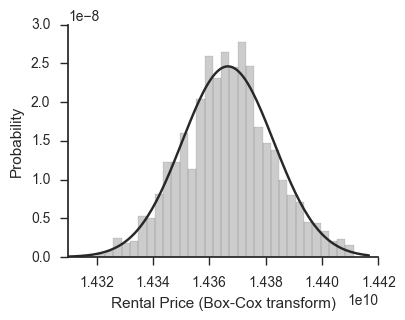

In [16]:
from scipy.stats import norm
from scipy.stats import boxcox
save_on=0
sns.set_context("notebook", font_scale=1.0)
plt.figure(figsize=(4,3))
bins_ = np.arange(1.42,1.445,.0005)
x = df.price[df.price<20000]
y,_ = boxcox(x)
y = y*(10**10)#we must rescale y to large values so that seaborn can plot a probability density
ax = sns.distplot(y,fit=norm, norm_hist=True, kde=False, hist_kws={"color": (0,0,0), "alpha": 0.2});
sns.set_style("ticks")
sns.despine()
ax.set_xlim([1.431*(10**10),1.442*(10**10)])
ax.set_xlabel('Rental Price (Box-Cox transform)')
ax.set_ylabel('Probability')
if save_on:
    plt.savefig('price_hist_boxcox.png',dpi=600)
    plt.savefig('price_hist_boxcox.pdf',format='pdf')

## sq_ft

Size of the apartment in square feet.

### Missing data

There is a lot of missing square footage data (%67.5 of listings).  The URLs were used to verify that this is not a flaw in the scraping algorithm, rather, many agents are choosing not to list this information.

In [22]:
df.loc[df['sq_ft']==-1,'sq_ft'] = np.nan
n_missing = sum(pd.isnull(df['sq_ft']))
print "Num observations missing sq_ft: ", np.sum(n_missing)
print "Pct observations missing sq_ft: ", 100*(float(np.sum(n_missing))/n)

Num observations missing sq_ft:  42715
Pct observations missing sq_ft:  67.5464119675


We cannot exclude all listings that are missing square footage information, but square footage is likely to be an important predictor of price.  Moreover, we see here that the data are not missing at random.  Units in which square footage is listed cost, on average, $1,505 more per month than units without square footage listed, meaning that the absence of square footage itself can provide information about price.  This can also be seen by plotting the distribution of price conditional on whether or not the square footage was listed.

In [26]:
#is there something systematic about price of units that do or do not list sq ft?
#mean price with sq ft listed, mean price without sq ft listed.
i_missing = pd.isnull(df['sq_ft'])
i_not_mis = pd.notnull(df['sq_ft'])

mean_missing = np.mean(df['price'][i_missing])
se_missing = np.std(df['price'][i_missing],ddof=1)/np.sqrt(sum(i_missing))
mean_not_mis = np.mean(df['price'][i_not_mis])
se_not_mis = np.std(df['price'][i_not_mis],ddof=1)/np.sqrt(sum(i_not_mis))

print "Missing sq_ft:"
print "mean =", mean_missing
print "se =", se_missing
print ""
print "Not missing sq_ft:"
print "mean =", mean_not_mis
print "se =", se_not_mis
print ""
print "Difference: ", mean_not_mis - mean_missing

Missing sq_ft:
mean = 3034.35036872
se = 14.1453077509
 
Not missing sq_ft:
mean = 4539.45787653
se = 40.3551160892

Difference:  1505.10750781


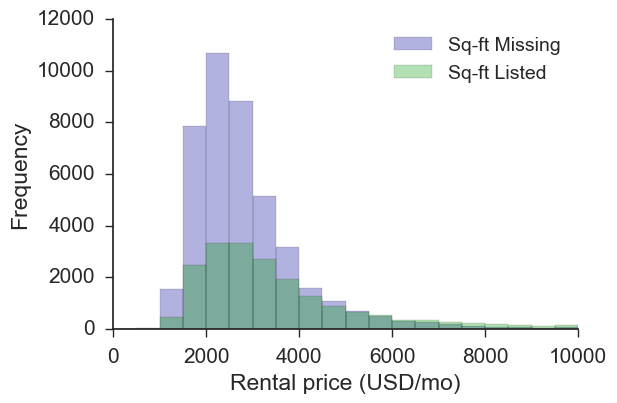

In [31]:
#plot freq distributions of prices for units with and without sq_ft listed
save_on = 0
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(6,4))
colors = ['red', 'tan', 'lime']
bins_ = np.arange(1,20000,500)
ax = sns.distplot(df['price'][i_missing],bins=bins_, kde=False, hist_kws={"color": (0,0,.6), "alpha": 0.3, "label": "Sq-ft Missing"});
ax = sns.distplot(df['price'][i_not_mis],bins=bins_, kde=False, hist_kws={"color": (0,.6,0), "alpha": 0.3, "label": "Sq-ft Listed"});
ax.set_axis_bgcolor((1,1,1))
ax.set_ylabel('Frequency')
ax.set_xlabel('Rental price (USD/mo)')
ax.set_xlim([0, 10000])
sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
if save_on == 1:
    plt.savefig('sq_ft_missing.png',dpi=600)
    plt.savefig('sq_ft_missing.pdf',format='pdf')

### Distribution.

The distribution of square footage is also highly skewed and may benefit from removal of outliers or transformations.  

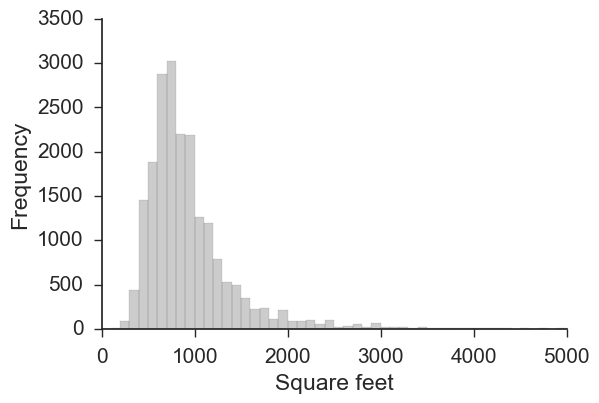

In [27]:
#plot overall distribution of square feet
save_on=0
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(6,4))
bins_ = np.arange(1,10000,100)
ax = sns.distplot(df.sq_ft[~np.isnan(df.sq_ft)],bins=bins_,kde=False, hist_kws={"color": (0,0,0), "alpha": 0.2});
ax.set_xlim([0,5000])
ax.set_xlabel('Square feet')
ax.set_ylabel('Frequency')
sns.set_style("ticks")
sns.despine()
if save_on:
    plt.savefig('price_hist_raw.png',dpi=600,edgecolor='k')
    plt.savefig('price_hist_raw.pdf',format='pdf')


Only %0.82 of the data fall above 4,000 sq feet.  

In [28]:
#what proportion of sq_ft greater than 4000?
pct_high_sq_ft = 100*float(np.sum(df.sq_ft > 4000))/float(np.sum(~np.isnan(df.sq_ft)))
print "%%%2.2f sq_ft > 4000" % (pct_high_sq_ft)

%0.82 sq_ft > 4000


Lastly, let's look at the relationship between square footage and location.  Here I use borough for simplicity although the neighborhood of each listing is available.  Lines here are simple linear regression fits for individual boroughs and the shading is a 95% confidence interval obtained using bootstrapping.  Clearly the influence of square foot on price depends on location and an interaction term is likely to improve prediction accuracy.  The relationship between square foot and price is roughly linear within a borough, with the exception being the upper tail of Manhattan which may benefit from a non-linear transformation.

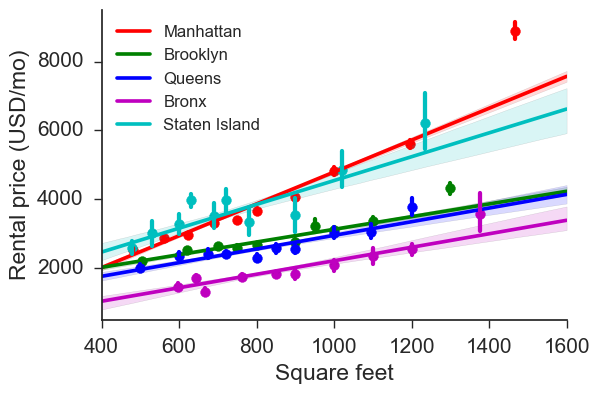

In [57]:
#flag saving
save_on=0

#break down by borough
color_map = {}
color_map['man'] = 'r'
color_map['bk'] = 'g'
color_map['q'] = 'b'
color_map['bx'] = 'm'
color_map['si'] = 'c'

max_sq_ft = 4000
df_man = df[(df.borough == 'Manhattan') & (df.price < 20000) & (df.unit_type == "Rental Unit") & ~np.isnan(df.sq_ft) & (df.sq_ft < max_sq_ft)]
df_bk = df[(df.borough == 'Brooklyn') & (df.price < 20000) & (df.unit_type == "Rental Unit") & ~np.isnan(df.sq_ft) & (df.sq_ft < max_sq_ft)]
df_q = df[(df.borough == 'Queens') & (df.price < 20000) & (df.unit_type == "Rental Unit") & ~np.isnan(df.sq_ft) & (df.sq_ft < max_sq_ft)]
df_bx = df[(df.borough == 'Bronx') & (df.price < 20000) & (df.unit_type == "Rental Unit") & ~np.isnan(df.sq_ft) & (df.sq_ft < max_sq_ft)]
df_si = df[(df.borough == 'Staten Island') & (df.price < 20000) & (df.unit_type == "Rental Unit") & ~np.isnan(df.sq_ft) & (df.sq_ft < max_sq_ft)]


plt.figure(figsize=(6,4))
ax = sns.regplot(x='sq_ft', y='price',data=df_man, x_bins=10, order = 1, color = color_map['man'], line_kws={"label": "Manhattan"}, ci=95)
ax = sns.regplot(x='sq_ft', y='price',data=df_bk, x_bins=10, order = 1, color = color_map['bk'], line_kws={"label": "Brooklyn"}, ci=95)
ax = sns.regplot(x='sq_ft', y='price',data=df_q, x_bins=10, order = 1, color = color_map['q'], line_kws={"label": "Queens"}, ci=95)
ax = sns.regplot(x='sq_ft', y='price',data=df_bx, x_bins=10, order = 1, color = color_map['bx'], line_kws={"label": "Bronx"}, ci=95)
ax = sns.regplot(x='sq_ft', y='price',data=df_si, x_bins=10, order = 1, color = color_map['si'], line_kws={"label": "Staten Island"}, ci=95)
sns.set_style("ticks")
sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', fontsize=12)
ax.set_xlim([400,1600])
ax.set_ylim([500,9500])
ax.set_xlabel('Square feet')
ax.set_ylabel('Rental price (USD/mo)')

if save_on == 1:
    plt.savefig('price_sqft_borough.png',dpi=600)
    plt.savefig('price_sqft_borough.pdf',format='pdf')

## Rooms

Total number of rooms in the unit including bedrooms and bathrooms.

### Missing values.

In [31]:
#check for missing vaues. 
n_missing = sum(df.rooms.isnull())
print "%d rooms missing" % (n_missing)


0 rooms missing


### Distribution

The distribution of rooms is reasonably well behaved.  There are a few units with >15 rooms (%0.03 of listings).  Checking the URLs associated with these listings suggest that the agent erroneously listed the number of rooms in the buliding rather than the actual rental unit and they can be removed.  One listing notes <1 room to indicate a small room and this seems to be a valid data point.  

(0, 12)

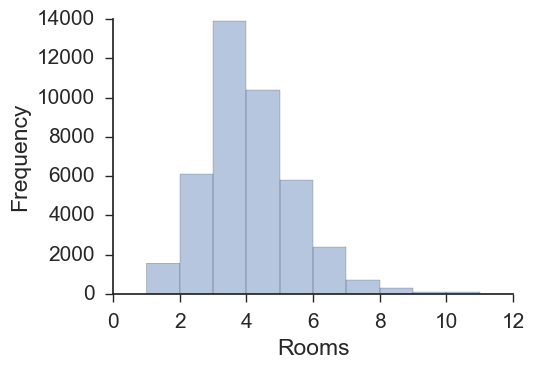

In [33]:
#freq distribution of rooms
bins_ = np.arange(1,15,1)
fig = plt.figure()
fig.add_axes([.2,.2,.5,.5])
ax = sns.distplot(df['rooms'],bins=bins_,norm_hist=False,kde=False);
sns.set_style("ticks")
sns.despine()
ax.set_ylabel('Frequency')
ax.set_xlabel('Rooms')
ax.set_xlim([0,12])

In [34]:
#count large numbers of rooms (>15)
pct_many_rooms = 100*float(np.sum(df['rooms']>15))/np.sum(~np.isnan(df['rooms']))
print "%%%2.2f rooms >15" % (pct_many_rooms)


%0.03 rooms >15


In [35]:
#Some listings include values <1.  
#Based on URLs, these seem to be legitimate values for smaller rooms.
# print "%d listings with <1 room" % ()
np.sum((df['rooms']<1) & (df['rooms'] > 0))

1

## Beds

Total number of bedrooms in the unit.

### Missing values

In [38]:
#check missing values.  Missing values have been changed to zero to imply studio.
n_missing = np.sum(np.isnan(df['beds']))
print "%d missing beds" % (n_missing)

0 missing beds


### Distribution.

The distribution for bedrooms seems reasonably well behaved.

(0, 12)

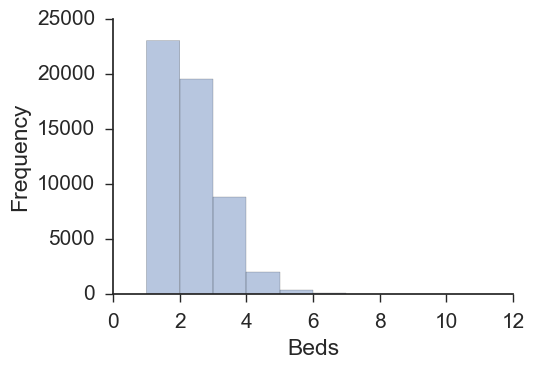

In [40]:
#freq distribution of rooms
bins_ = np.arange(1,8,1)
fig = plt.figure()
fig.add_axes([.2,.2,.5,.5])
ax = sns.distplot(df['beds'],bins=bins_,norm_hist=False,kde=False)
sns.set_style("ticks")
sns.despine()
ax.set_ylabel('Frequency')
ax.set_xlabel('Beds')
ax.set_xlim([0,12])

In [43]:
#check for extreme values
df[df['beds']>8]
#number of beds > 8
pct_many_beds = 100*float(np.sum(df['beds']>8))/np.sum(~np.isnan(df['beds']))
print "%%%1.3f beds > 8" % (pct_many_beds)

%0.005 beds > 8


### Baths

Total number of bathrooms in the unit.

### Missing values.

In [48]:
#check missing
n_missing = sum(df['baths'].isnull())
print "%d missing baths" % (n_missing)

0 missing baths


### Distribution.

(0.5, 8)

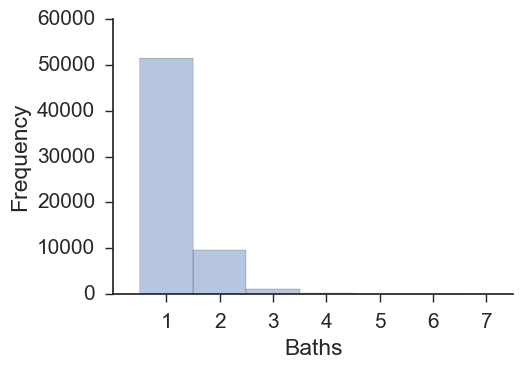

In [50]:
#freq distribution of baths
bins_ = np.arange(1,8,1)
fig = plt.figure()
fig.add_axes([.2,.2,.5,.5])
ax = sns.distplot(df['baths'],bins=bins_,norm_hist=False,kde=False);
sns.set_style("ticks")
sns.despine()
ax.set_xticks(bins_+0.5)
ax.set_xticklabels(bins_)
ax.set_ylabel('Frequency')
ax.set_xlabel('Baths')
ax.set_xlim([0.5,8])

In [46]:
#check extreme values
pct_many_baths = 100*float(np.sum(df['baths']>6))/np.sum(~np.isnan(df['baths']))
print "%%%2.3f baths > 6" % (pct_many_baths)

%0.047 baths > 6


# unit_type

Type of rental unit: Condo, Rental Unit, Co-op, Townhouse, Condop, Multi-family, Apartment, Building, House, or Other type.

### Missing values.

In [53]:
n_missing = sum(df['unit_type'].isnull())
print "%d missing unit_type" % (n_missing)

0 missing unit_type


### Mean value by unit type.

Bars show the mean price for each unit type (error bars are SE).  Clearly there is substantial variation in the mean price depending on the type of unit.  This is likely to be a highly informative predictor.

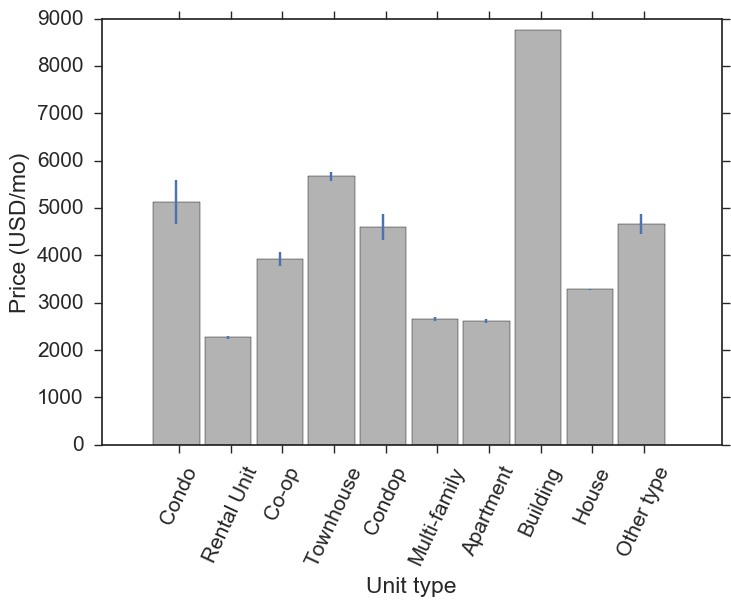

In [45]:
#plot price by unit type.
unit_type_list = df['unit_type'].unique()
ind = np.arange(len(unit_type_list))+1
width = 0.9
mean_price = df.groupby('unit_type').mean()['price']
std_price = df.groupby('unit_type').std()['price']
n_price = df.groupby('unit_type').count()['price']
se_price = std_price/np.sqrt(n_price)

fig, ax = plt.subplots()
rects1 = ax.bar(ind, mean_price, width, color=(.7,.7,.7), yerr=se_price)
ax.set_xticks(ind+0.5)
ax.set_xticklabels(unit_type_list,rotation = 65)
ax.set_ylabel('Price (USD/mo)')
ax.set_xlabel('Unit type')

# neighborhood

In which NYC neighborhood is the unit located?

### Missing values.

In [50]:
#check missing
n_missing = sum(df['neighborhood'].isnull())
print "%d missing neighborhood" % (n_missing)


0 missing neighborhood


### Mean price by neighborhood

Clearly there is substatial variation in price by neighborhood.  Likely to be a highly informative predictor.

(0, 264)

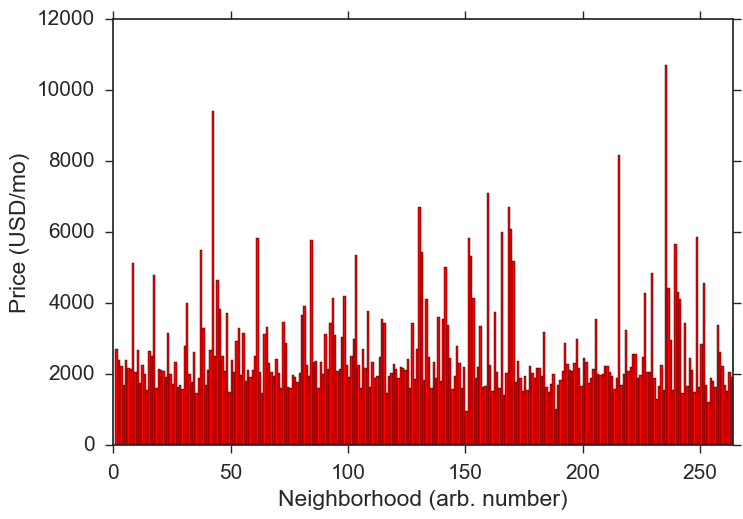

In [55]:
#plot price by neighborhood.
nhood_list = df['neighborhood'].unique()
ind = np.arange(len(nhood_list))+1
width = 1

#use groupby
mean_price = df.groupby('neighborhood').mean()['price']
std_price = df.groupby('neighborhood').std()['price']
n_price = df.groupby('neighborhood').count()['price']
se_price = std_price/np.sqrt(n_price)
fig, ax = plt.subplots()
rects1 = ax.bar(ind, mean_price, width, color='r')
ax.set_ylabel('Price (USD/mo)')
ax.set_xlabel('Neighborhood (arb. number)')
ax.set_xlim([0,np.max(ind)])

## Transportation

Distance (in mi) from the listing to nearby public transportation (subway lines or trains).

### Mean price by number of public transportion stops within 1.8 mi.

We see a clear increase in the price with an increase in nearby transportation.  This variable could potentially be informative for model development.  Note, however, that this analysis ignored the relationship to other predictors.  For example, the number of nearby public transportation stops also varies by neighborhood.

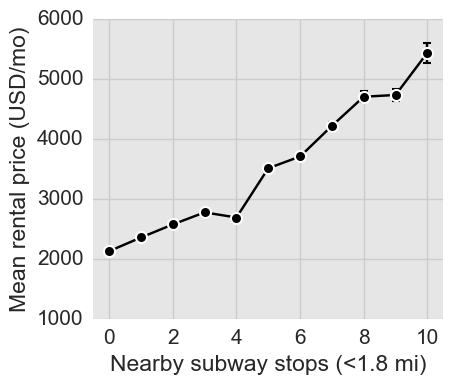

In [52]:
save_on=0

#plot price by number of nearby sub stops
sub_list = ["line_A","line_C","line_E","line_B","line_D","line_F","line_M","line_G","line_L",
           "line_J","line_Z","line_N","line_Q","line_R","line_1","line_2","line_3","line_4","line_5","line_6",
           "line_7","line_S","LIRR","PATH"]
df_subs = df[sub_list].copy()
df_subs[df_subs>0] = 1
n_subs = df_subs.apply(sum,axis=1)

max_subs = int(max(n_subs))
max_subs = 10
mean_price = df['price'].groupby(n_subs).mean()
std_price = df['price'].groupby(n_subs).std()
n_price = df['price'].groupby(n_subs).count()
se_price = std_price/np.sqrt(n_price)

#plot
fig = plt.figure(figsize=(7,6))
sns.set_style("darkgrid",{"grid.color": (0.8,0.8,0.8)})
ax = fig.add_axes([.2,.2,.5,.5])
ax.errorbar(np.arange(0,max_subs+1,1),mean_price[np.arange(0,max_subs+1,1)],yerr=se_price[np.arange(0,max_subs+1,1)],
           color='k',marker='o',markersize=8,markeredgecolor='w',markeredgewidth=1.5)
ax.set_xlabel('Nearby subway stops (<1.8 mi)')
ax.set_ylabel('Mean rental price (USD/mo)')
ax.set_yticks([1000,2000,3000,4000,5000,6000])
plt.rc('font',size=50)
ax.set_xlim([-0.5, max_subs+0.5])
ax.set_axis_bgcolor((0.9,0.9,.9))
if save_on==1:
    plt.savefig('price_n_stops.pdf',format='pdf')

### Price as a function of distance to subway lines.

We see a clear decrease in price as the distance to nearby subway lines increases.  This is another potentially informative predictor.

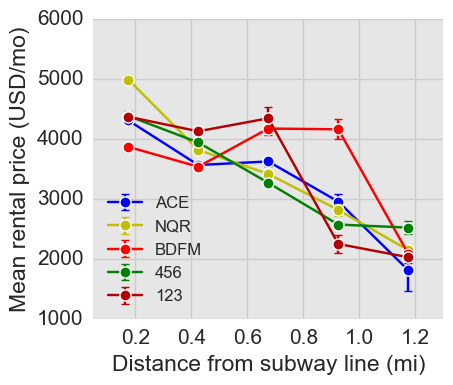

In [53]:
#save flag
save_on = 0

#combine across trains within a line
mean_price = {}
std_price = {}
n_price = {}
se_price = {}
bins = np.arange(0.05,1.5,0.25);

#define the category bins
categories = {}
categories['ace'] = pd.cut(df['line_A' or 'line_C' or 'line_E'], bins)
categories['nqr'] = pd.cut(df['line_N' or 'line_Q' or 'line_R'], bins)
categories['bdfm'] = pd.cut(df['line_B' or 'line_D' or 'line_F' or 'line_M'], bins)
categories['456'] = pd.cut(df['line_4' or 'line_5' or 'line_6'], bins)
categories['123'] = pd.cut(df['line_1' or 'line_2' or 'line_3'], bins)

#compute mean/se for each bin
mean_price = {}
std_price = {}
n_price = {}
se_price = {}
for c in categories.keys():
    mean_price[c] = df['price'].groupby(categories[c]).mean()
    std_price[c] = df['price'].groupby(categories[c]).std()
    n_price[c] = df['price'].groupby(categories[c]).count()
    se_price[c] = std_price[c]/np.sqrt(n_price[c])

#plot
fig = plt.figure(figsize=(7,6))
sns.set_style("darkgrid",{"grid.color": (0.8,0.8,0.8)})
ax = fig.add_axes([.2,.2,.5,.5])
n_bins = len(bins)
bin_labels = [np.mean([bins[0],bins[1]]),
              np.mean([bins[1],bins[2]]),
              np.mean([bins[2],bins[3]]),
              np.mean([bins[3],bins[4]]),
              np.mean([bins[4],bins[5]])
              ]
plt.errorbar(bin_labels,mean_price['ace'],yerr=se_price['ace'],
             color='b', marker='o',markersize=8,markeredgecolor=(1,1,1),markeredgewidth=1.0,label='ACE')
plt.errorbar(bin_labels,mean_price['nqr'],yerr=se_price['nqr'],
             color='y', marker='o',markersize=8,markeredgecolor=(1,1,1),markeredgewidth=1.0,label='NQR')
plt.errorbar(bin_labels,mean_price['bdfm'],yerr=se_price['bdfm'],
             color=(255/255,65/255,0), marker='o',markersize=8,markeredgecolor=(1,1,1),markeredgewidth=1.0,label='BDFM')
plt.errorbar(bin_labels,mean_price['456'],yerr=se_price['456'],
             color='g', marker='o',markersize=8,markeredgecolor=(1,1,1),markeredgewidth=1.0,label='456')
plt.errorbar(bin_labels,mean_price['123'],yerr=se_price['123'],
             color=(.7,0,0), marker='o',markersize=8,markeredgecolor=(1,1,1),markeredgewidth=1.0,label='123')
ax.set_xlim([min(bins),max(bins)])
ax.set_axis_bgcolor((0.9,0.9,.9))
ax.set_yticks([1000,2000,3000,4000,5000,6000])
ax.set_xlabel('Distance from subway line (mi)')
ax.set_ylabel('Mean rental price (USD/mo)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='lower left', fontsize=12)

if save_on==1:
    plt.savefig('dist_sub_line.pdf',format='pdf')
    plt.savefig('dist_sub_line.png',dpi=600)
